In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""Change to the data folder"""
new_path = "../new_train/new_train"

# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

### Create a dataset class 

In [5]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
val_dataset = ArgoverseDataset(data_path=new_path)
len(val_dataset)

205942

In [183]:
scene = val_dataset[0]
track_id = scene["track_id"]
car_mask = scene["car_mask"]
len(scene["p_out"][0])

30

### Create a loader to enable batch processing

In [77]:
batch_sz = 1

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    inp = torch.LongTensor(inp)
    out = torch.LongTensor(out)
    car_mask = torch.LongTensor(scene['car_mask'])
    return [inp, out, car_mask]

val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0)

### Visualize the batch of sequences

In [6]:
import matplotlib.pyplot as plt
import random
import sys
import pandas as pd

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

def show_pos_distribution(dataset, field_name, orientation, sampling_rate):
    x_positions = []
    filename = field_name + "-" + orientation
    print(filename)
    direction = 0
    if orientation == 'y':
        direction = 1
        
    for i in range(len(dataset)):
        scene = dataset[i]
        car_mask = scene['car_mask']
        p_in = scene[field_name]
        for j in range(len(p_in)):
            # find the actual objects
            if car_mask[j] == 1.0:
                x_positions.append([p_in[j][k][direction] for k in range(0, len(p_in[j]), sampling_rate)])
        if i%10000 == 0:
            print(i)
    
    # flatten the nested list
    x_positions = [position for pos_list in x_positions for position in pos_list]
    x_bins = numpy.linspace(min(x_positions), max(x_positions), 50)
    plt.hist(x_positions, x_bins, alpha=1.0, label="x-positions")
    plt.title(filename)
    plt.show()
    plt.savefig(filename+".png")

p_in-x
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


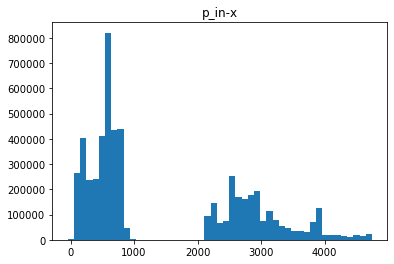

p_in-y
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


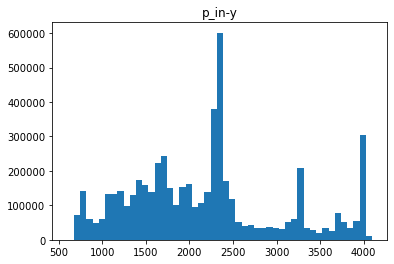

p_out-x
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


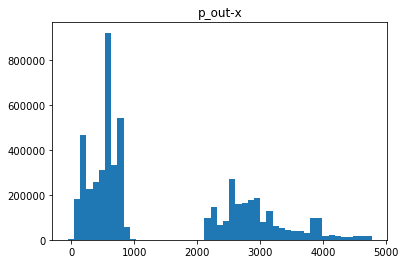

p_out-y
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


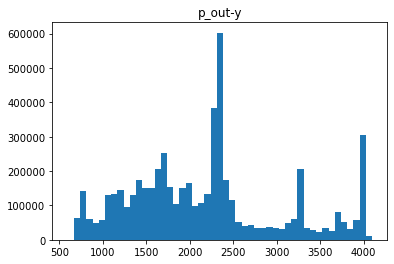

<Figure size 432x288 with 0 Axes>

In [7]:
show_pos_distribution(val_dataset, 'p_in', 'x', 8)
show_pos_distribution(val_dataset, 'p_in', 'y', 8)
show_pos_distribution(val_dataset, 'p_out', 'x', 14)
show_pos_distribution(val_dataset, 'p_out', 'y', 14)

In [18]:
import math
import numpy as np

def calc_magnitude(velocity):
    return math.sqrt(velocity[0]**2 + velocity[1]**2)

def show_vel_distribution(dataset, target):
    velocities = []
    filename = "vel"
    if target == True:
        filename += "-target"
        
    for i in range(len(dataset)):
        scene = dataset[i]
        car_mask = scene['car_mask']
        v = scene['v_in']
        agent_idx = np.where(scene["agent_id"] == np.unique(scene["track_id"].flatten()))[0][0]
        if target == True:
            velocities.append([calc_magnitude(v[agent_idx][k]) for k in range(0, len(v[agent_idx]), 8)])
        else:
            for j in range(len(v)):
                if car_mask[j] == 1.0 and j != agent_idx:
                    velocities.append([calc_magnitude(v[j][k]) for k in range(0, len(v[j]), 8)])
        if i%10000 == 0:
            print(i)
                    
    # flatten the nested list
    velocities = [velocity for vel_list in velocities for velocity in vel_list]
    bins = numpy.linspace(0, 80, 50)
    plt.hist(velocities, bins, alpha=1.0, label="x-positions")
    plt.title(filename)
    plt.show()
    plt.savefig(filename+".png")

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


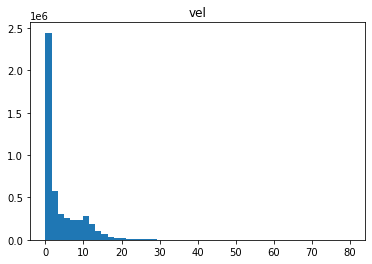

<Figure size 432x288 with 0 Axes>

In [19]:
show_vel_distribution(val_dataset, False)


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


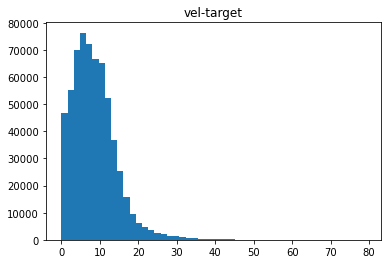

<Figure size 432x288 with 0 Axes>

In [17]:
show_vel_distribution(val_dataset, True)